# <u>Multivariate Outlier Detection in Geochemical Datasets</u>

This notebook is intended as an open-source resource for exploring, analyzing and comparing three different methods of outlier detection in geochemical datasets in the context of mineral exploration.  
<br />
<br />
The three primary outlier detection algorithms we will use are the following: 
- Isolation Forests (IF) (Liu et al., 2008)
- Local Outlier Factor (LOF) (Breunig et al., 2000)
- Angle Based Outlier Detection (ABOD) (Shahrestani & Sanislav, 2025)
<br />
<br />

This work is driven from the findings in Antoine Caté's article on multivariate outlier detection for mineral exploration.

<br />
<br />
<u>References: </u>

*Breunig, M. M., Kriegel, H.-P., Ng, R. T., and Sander, J., 2000, LOF: Identifying Density-Based Local Outliers: ACM SIGMOD Record, v. 29, no. 2, p. 93-104.*

*Liu, F. T., Ting, K. M., and Zhou, Z.-H., 2008, Isolation Forest, 2008 Eighth IEEE International Conference on Data Mining, p. 413-422.*

*Maklin, C., 2022, Isolation Forest - Cory Maklin - Medium: Medium, https://medium.com/@corymaklin/isolation-forest-799fceacdda4.*

*Shahrestani, S., and Sanislav, I., 2025, Mapping geochemical anomalies using angle-based outlier detection approach: Journal of Geochemical Exploration, v. 269.*
<br />

---

In [56]:
import pandas as pd
import geopandas as gpd
import time
import matplotlib.pyplot as plt
import seaborn as sns

import helper_functions
import outlier_detection_functions
from shapely.geometry import Point


import importlib

importlib.reload(helper_functions)
importlib.reload(outlier_detection_functions)

<module 'outlier_detection_functions' from '/Users/thowe/Documents/Work/geo_datasci_tools/geochemical_outlier_detection/outlier_detection_functions.py'>

*For the testing of these algorithms we are going to use geochemical data from a region in southeastern Alaska, USA. All units are converted to ppm for consistency.*

In [3]:
# Import and preview the data
data_filepath = "/Users/thowe/MinersAI Dropbox/Tyler Howe/AK_sample_project/UNPROCESSED/misc_processing_files/agdb_merged.csv"
#data_filepath = r"C:\Users\TyHow\MinersAI Dropbox\Tyler Howe\AK_sample_project\UNPROCESSED\misc_processing_files\agdb_merged.csv"
df_raw = pd.read_csv(data_filepath)
print(df_raw.head(3))
print("\nColumns in dataset:", df_raw.columns)

# Load GeoJSON polygon mask
geojson_path = "/Users/thowe/MinersAI Dropbox/Tyler Howe/AK_sample_project/PROCESSED/processed_data/AK_MASK.geojson"
#geojson_path = r"C:\Users\TyHow\MinersAI Dropbox\Tyler Howe\AK_sample_project\PROCESSED\processed_data\AK_MASK.geojson"
polygon = gpd.read_file(geojson_path).geometry.unary_union

# Clip DataFrame to the GeoJSON polygon
df_clipped = df_raw[
    df_raw.apply(lambda row: polygon.contains(Point(row["longitude"], row["latitude"])), axis=1)
]

   lab_id    Ag_ppm     As_ppm  Au_ppm     B_ppm  Ba_ppm    Be_ppm    Bi_ppm  \
0  62M110  0.233333  66.666667     NaN  2.333333   700.0  0.333333  2.333333   
1  62M111  0.233333  66.666667     NaN  2.333333   700.0  0.333333  2.333333   
2  62M112  0.233333  66.666667     NaN  2.333333   500.0  0.333333  2.333333   

      Cd_ppm     Ce_ppm  ...  Tm_ppm       U_ppm  V_ppm  W_ppm  Y_ppm  Yb_ppm  \
0  16.666667  23.333333  ...     NaN  166.666667  150.0   10.0   20.0     2.0   
1  16.666667  23.333333  ...     NaN  166.666667  150.0   10.0   20.0     3.0   
2  16.666667  23.333333  ...     NaN  166.666667  200.0   10.0   30.0     3.0   

      Zn_ppm  Zr_ppm  latitude  longitude  
0  33.333333   100.0  59.55271 -154.49172  
1  33.333333    70.0  59.50931 -154.49273  
2  33.333333   150.0  59.50281 -154.47538  

[3 rows x 63 columns]

Columns in dataset: Index(['lab_id', 'Ag_ppm', 'As_ppm', 'Au_ppm', 'B_ppm', 'Ba_ppm', 'Be_ppm',
       'Bi_ppm', 'Cd_ppm', 'Ce_ppm', 'Co_ppm', 'Cr_ppm', '

/var/folders/xc/wpkwk17x20z44scclf26ttt80000gn/T/ipykernel_72172/340470180.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gpd.read_file(geojson_path).geometry.unary_union


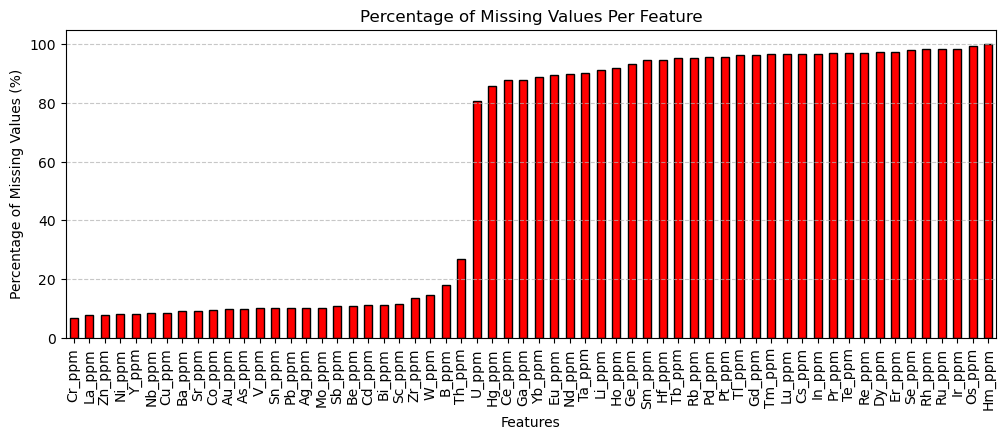

In [4]:
# Plot percentage of missing data in each column
helper_functions.plot_nan_percentage(df_clipped)

In [5]:
# Remove columns with more than 90% missing data, fill missing data with median
df = df_clipped.copy()
df = helper_functions.clean_geochemical_data(df, nan_threshold=0.6, mode_threshold=0.4)
print(f"Columns in cleaned dataset: {df.columns}")

Dropped columns: As_ppm, Rb_ppm, Ir_ppm, Hm_ppm, Ga_ppm, Nd_ppm, Lu_ppm, Te_ppm, Gd_ppm, Sb_ppm, Pt_ppm, Nb_ppm, Dy_ppm, Rh_ppm, Au_ppm, W_ppm, Hf_ppm, B_ppm, Ag_ppm, In_ppm, Yb_ppm, Hg_ppm, Tm_ppm, Se_ppm, Bi_ppm, Ge_ppm, Li_ppm, Cs_ppm, Pr_ppm, Pd_ppm, Mo_ppm, Ta_ppm, Ru_ppm, Sm_ppm, Eu_ppm, Re_ppm, Ce_ppm, Th_ppm, Ho_ppm, U_ppm, Sn_ppm, Cd_ppm, Tb_ppm, Os_ppm, Er_ppm, Tl_ppm
Remaining NaNs filled with column medians.
Columns in cleaned dataset: Index(['lab_id', 'Ba_ppm', 'Be_ppm', 'Co_ppm', 'Cr_ppm', 'Cu_ppm', 'La_ppm',
       'Ni_ppm', 'Pb_ppm', 'Sc_ppm', 'Sr_ppm', 'V_ppm', 'Y_ppm', 'Zn_ppm',
       'Zr_ppm', 'latitude', 'longitude'],
      dtype='object')


In [6]:
# List of all geochemical columns to be used in the analysis - omits sample number and location columns
feature_columns = [
    col for col in df.columns if col not in ["lab_id", "latitude", "longitude"]
]

print(f"Selected feature columns: {feature_columns}")

Selected feature columns: ['Ba_ppm', 'Be_ppm', 'Co_ppm', 'Cr_ppm', 'Cu_ppm', 'La_ppm', 'Ni_ppm', 'Pb_ppm', 'Sc_ppm', 'Sr_ppm', 'V_ppm', 'Y_ppm', 'Zn_ppm', 'Zr_ppm']


### <u>Simple EDA on the data</u>

To start off, let's do a brief investigation into broad trends or relationships in the data to get a sense of what we are working with. 

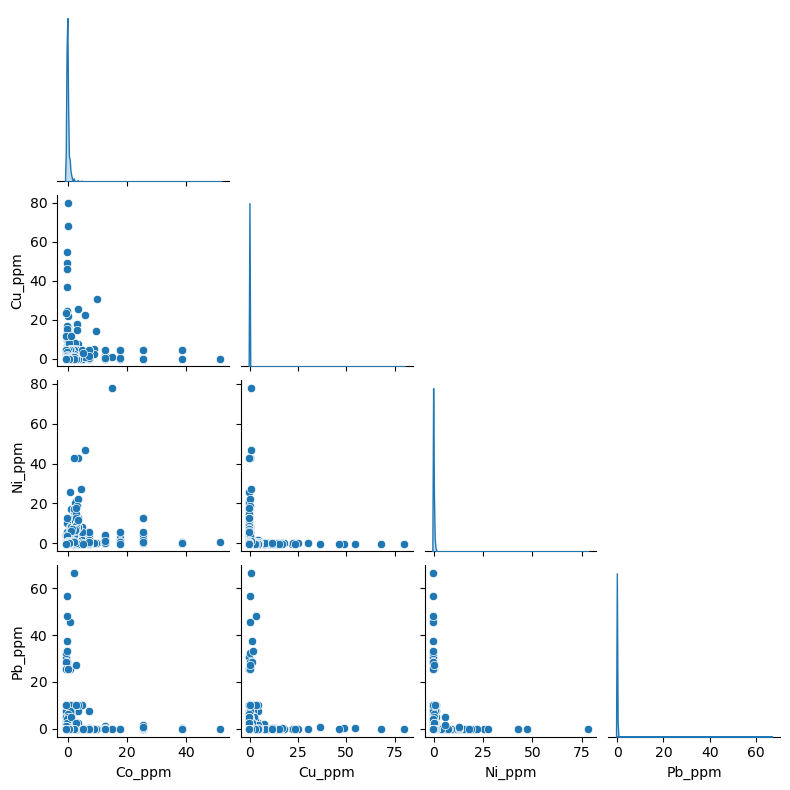

In [7]:
# Generate pairplot of select elements
elements_to_plot = ["Co_ppm", "Cu_ppm", "Ni_ppm", "Pb_ppm"]  # Choose key elements - ideally those related to mineralization or other interesting trends
helper_functions.generate_pairplot(df, elements_to_plot, height=2)

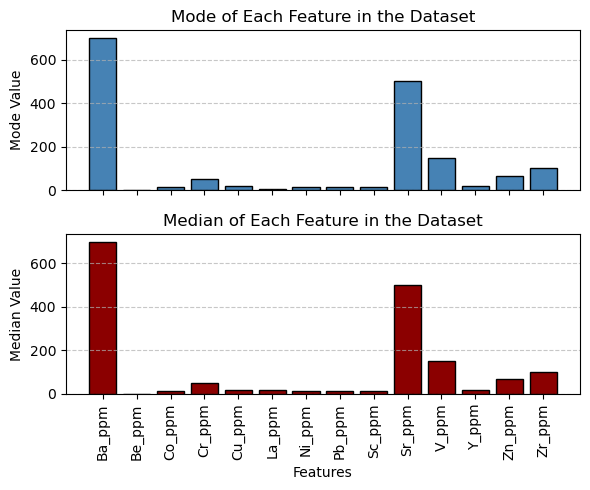

In [8]:
# Compute mode (first mode value) and median for each feature

helper_functions.plot_mode_median(df, feature_columns)

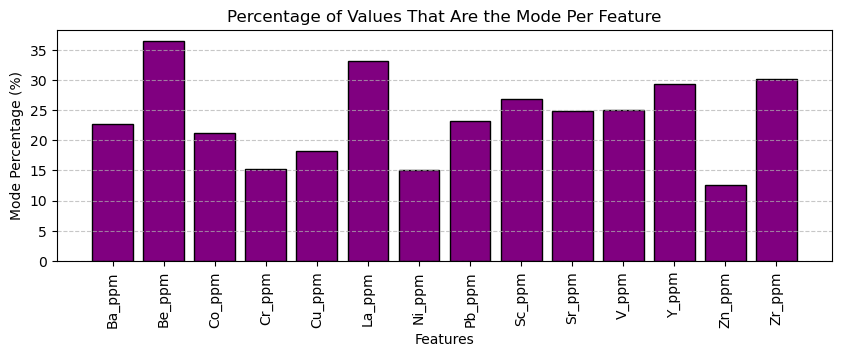

In [9]:
# Count number of modes per column

helper_functions.plot_mode_percentage(df, feature_columns)

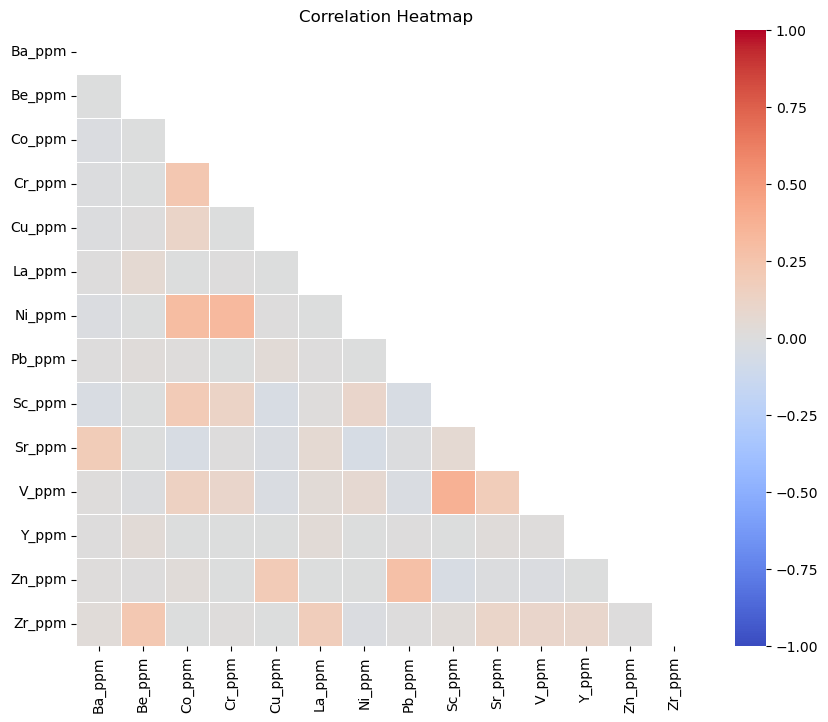

In [10]:
# Generate correlation heatmap
helper_functions.plot_correlation_heatmap(df, feature_columns, figsize=(10,8), annot=False) # Increase figsize to view all element labels

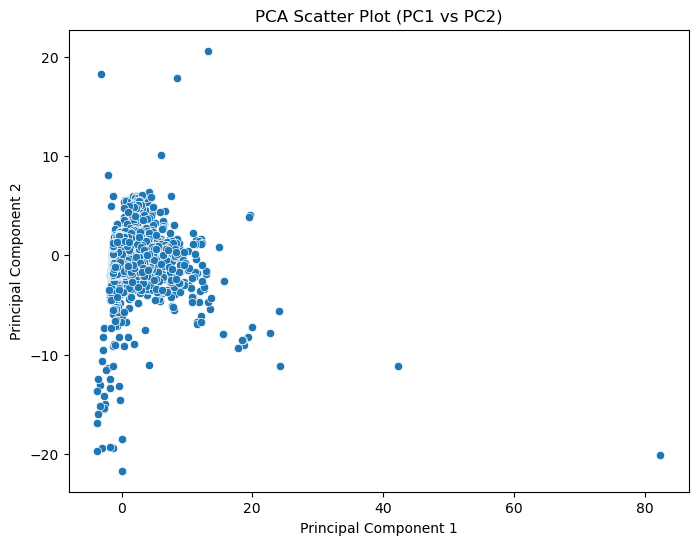

Top 5 Contributing Features to PC1: ['Co_ppm', 'Sc_ppm', 'Ni_ppm', 'Cr_ppm', 'V_ppm']
Top 5 Contributing Features to PC2: ['latitude', 'longitude', 'Sr_ppm', 'Zn_ppm', 'Cu_ppm']


In [11]:
# PCA
pc1_scores, top_features1, top_features2 = helper_functions.generate_pca(df)
print("Top 5 Contributing Features to PC1:", top_features1)
print("Top 5 Contributing Features to PC2:", top_features2)

---

## <u>Outlier Detection Methods</u>

Outliers in the binary plots below are classified using the Modified Z-Score method based on the Median Absolute Deviation (MAD). Data points with a modified Z-score greater than 3.5 are labeled as outliers (-1). This is done in place of the standard Contamination value, as it is hard to manually estimate the proportion of outliers in the datset.

### <u>Isolation Forest</u>

Isolation forest is an unsupervised machine learning method of outlier/anomaly detection. It is an ensemble method that combines the predictions of several decision trees to assign an anomaly score to a given data point. Samples that require fewer splits across all trees are given a lower anomaly score (higher likelihood of being anomalous). This method of outlier detection is not affected by data distribution, but does require some parameter-tuning. 

In [12]:
IF_df = outlier_detection_functions.isolation_forest(
    df, feature_columns
)

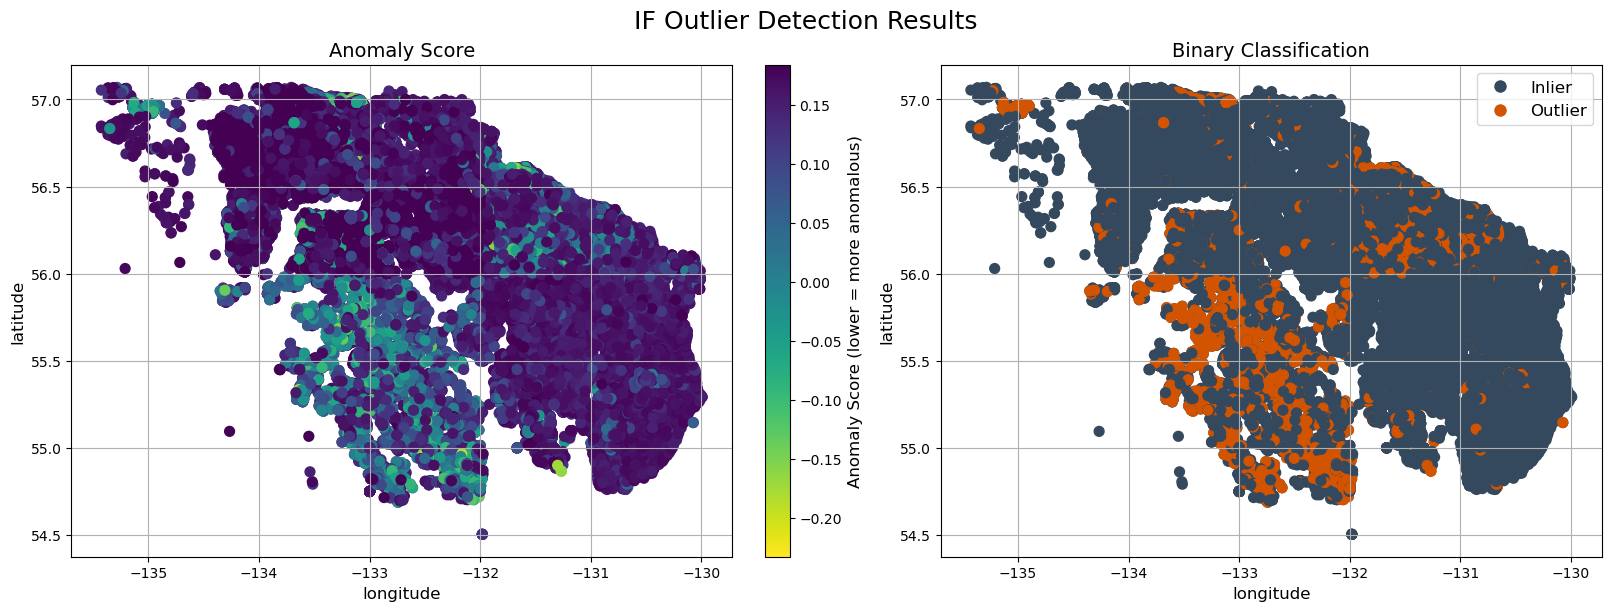

Classified 3415 outliers out of 30112 samples


In [13]:
# Plotting IF results
helper_functions.plot_outlier_results(
    data=IF_df,
    x_col="longitude",
    y_col="latitude",
    score_col="anomaly_score",
    binary_col="outlier",
    point_size=50,
    plot_title="IF Outlier Detection Results",
    cmap='viridis_r'
)


---

### <u>Local Outlier Factor</u>

LOF is another unsupervised outlier detection method that uses a density-based approach, comparing the density of data points in their local neighborhoods. Isolated samples or those on the margins of a neighborhood cluster will have a lower density than their neighbors. Samples with a lower LOF value are considered outliers. Similar to IF, LOF is unaffected by data distribution but does require some parameter-tuning.

In [14]:
LOF_df = outlier_detection_functions.local_outlier_factor(
    df, feature_columns, n_neighbors=50, scale_data=False
)

/opt/anaconda3/envs/geo_env/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


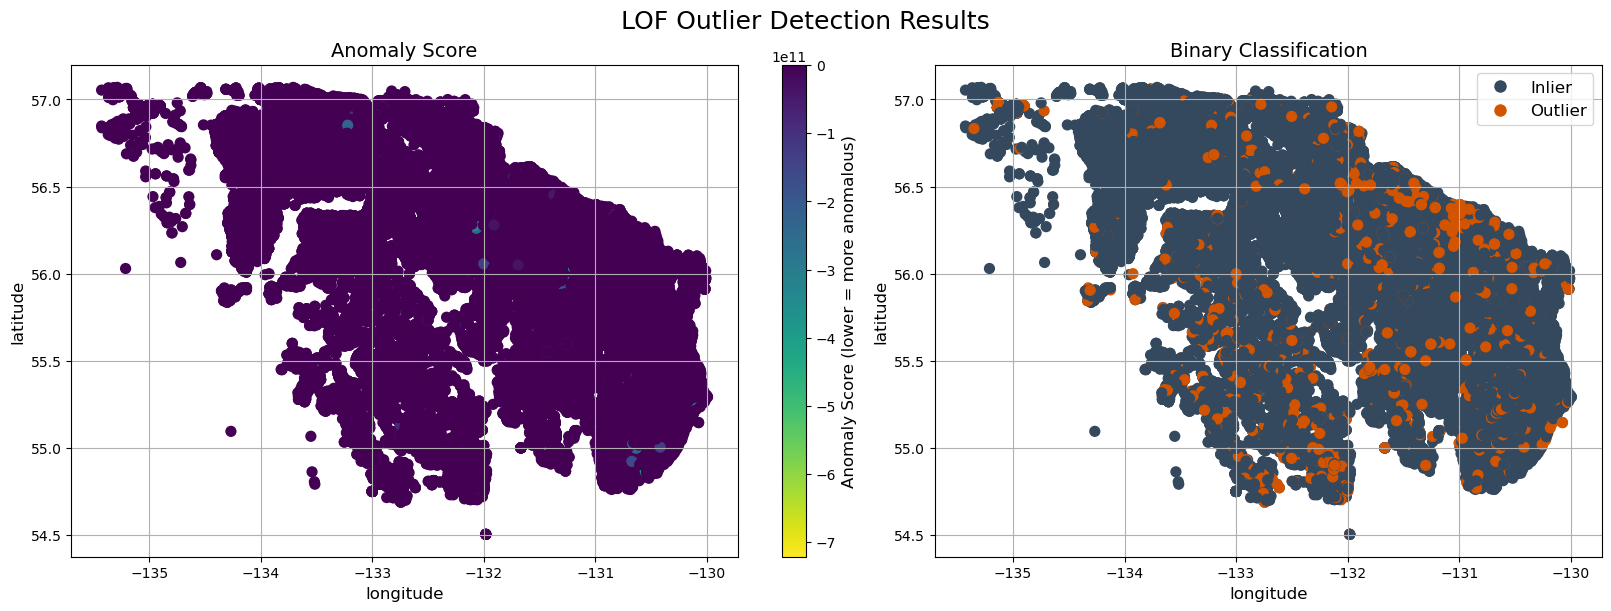

Classified 2371 outliers out of 30112 samples


In [15]:
# Plotting LOF results
helper_functions.plot_outlier_results(
    data=LOF_df,
    x_col="longitude",
    y_col="latitude",
    score_col="anomaly_score",
    binary_col="outlier",
    point_size=50,
    plot_title="LOF Outlier Detection Results",
    cmap="viridis_r",
)


---

### <u>Angle Based Outlier Detection</u>

Our final method of outlier detection is angle based outlier detection. This method compares the distribution of angles of distance vectors between a sample point and its neighbors; a point with a large distribution of vector angles is considered an inlier (within a cluster), while a point with a smaller distribution of angles is likely an outlier (outside a cluster). An angle-based score is then calculated, with less variation indicating a higher probability of the sample point being an outlier. One benefit of ABOD is that it is free of any parameters, and thus does not have the potential prediction variability resulting from tuning. Its implementation does not, however, output a binary classification, thus in order to generate one an arbitrary threshold must be defined. 

In [58]:
ABOD_df = outlier_detection_functions.abod(df, feature_columns, scale_data=True, use_knn=True, k_neighbors=10)

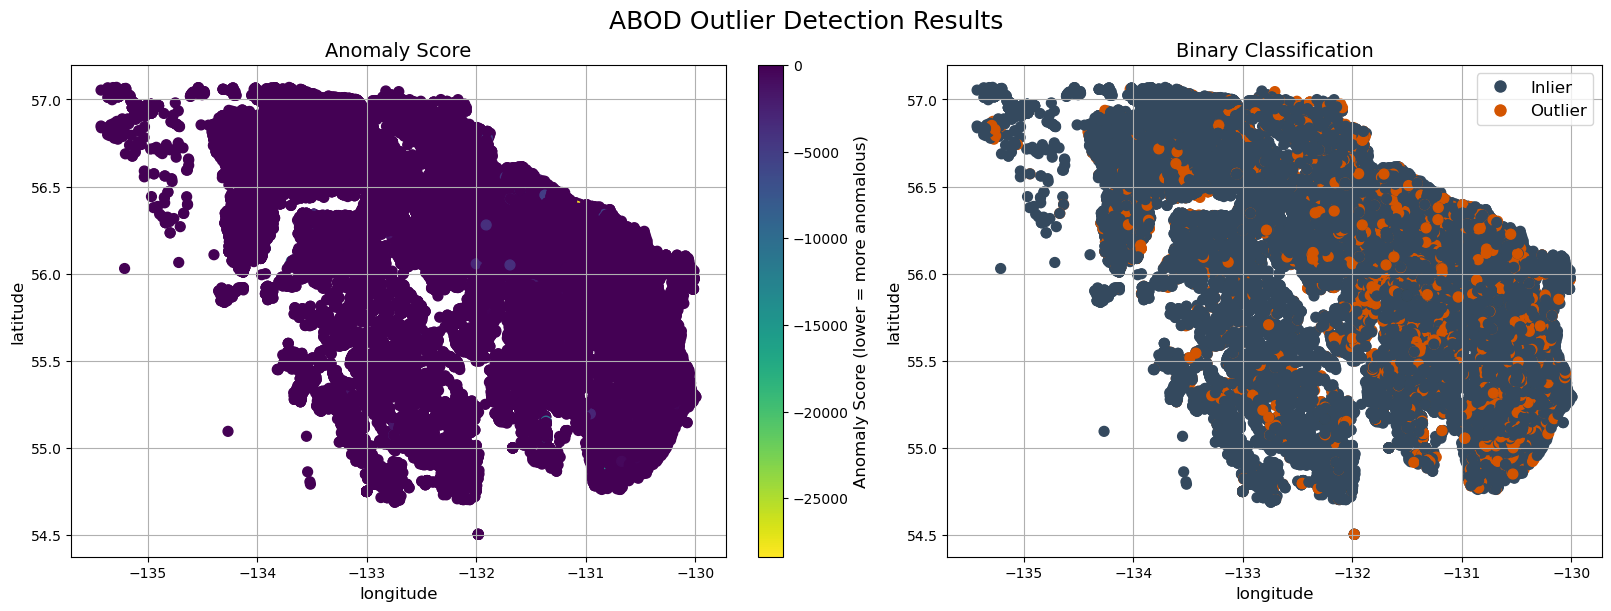

Classified 4356 outliers out of 30112 samples


In [59]:
# Plotting ABOD results
helper_functions.plot_outlier_results(
    data=ABOD_df,
    x_col="longitude",
    y_col="latitude",
    score_col="anomaly_score",
    binary_col="outlier",
    point_size=50,
    plot_title="ABOD Outlier Detection Results",
    cmap="viridis_r",
)

In [60]:
import numpy as np
print(np.min(ABOD_df["anomaly_score"]))
print(np.max(ABOD_df["anomaly_score"]))

-28372.435667300688
0.005749676272773315


---

## <u>Validation of predictions</u>

Multivariate anomaly detection picks up on trends across multiple elements, rather than just single-element variation. As opposed to univariate anomalies that may be attributed to noise, sampling error, or highly-localized trends, multivariate analysis may point towards regions of broader geologic alteration related to mineral deposits. To test this relationship, we will compare outlier predictions from each model against known mineral occurrences in the sampling region. 

In [23]:
# Import validation dataset

# validation_filepath = r"C:\Users\TyHow\MinersAI Dropbox\Tyler Howe\AK_sample_project\PROCESSED\processed_data\ardf_processed.geojson"
validation_filepath = "/Users/thowe/MinersAI Dropbox/Tyler Howe/AK_sample_project/PROCESSED/processed_data/ardf_processed.geojson"

validation_gdf = gpd.read_file(validation_filepath)
validation_df = validation_gdf.copy()
validation_df['Longitude'] = validation_df['geometry'].x
validation_df['Latitude'] = validation_df['geometry'].y
validation_df.drop(columns='geometry', inplace=True)

In [ ]:
best_k = None
best_score = 0
k_values = range(10, 1010, 100)  # Adjust range as needed
roc_auc_results = {}

for k in k_values:
    print(f"Testing k={k}...")

    # Run ABOD with current k_neighbors
    ABOD_df = outlier_detection_functions.abod(
        df, feature_columns, scale_data=True, use_knn=True, k_neighbors=k
    )

    # Compute ROC-AUC score
    roc_auc_score = helper_functions.calculate_roc_auc(
        [ABOD_df],  # Ensure it's in a list format
        ["ABOD"],
        validation_df,
        radius=0.005,
        x_col="longitude",
        y_col="latitude",
    )[
        "ABOD"
    ]  # Extract score for ABOD

    # Store results
    roc_auc_results[k] = roc_auc_score

    # Update best k if score improves
    if roc_auc_score > best_score:
        best_score = roc_auc_score
        best_k = k

print(f"Optimal k_neighbors: {best_k} with ROC-AUC score: {best_score}")

### *Spatial validation of outlier predictions*

To start, we will conduct a visual analysis on the data, comparing binary outlier classifications vs. known mineral occurrences in the region.

Points detected as outliers by 1 model: 5404
Points detected as outliers by 2 models: 1316
Points detected as outliers by all 3 models: 104


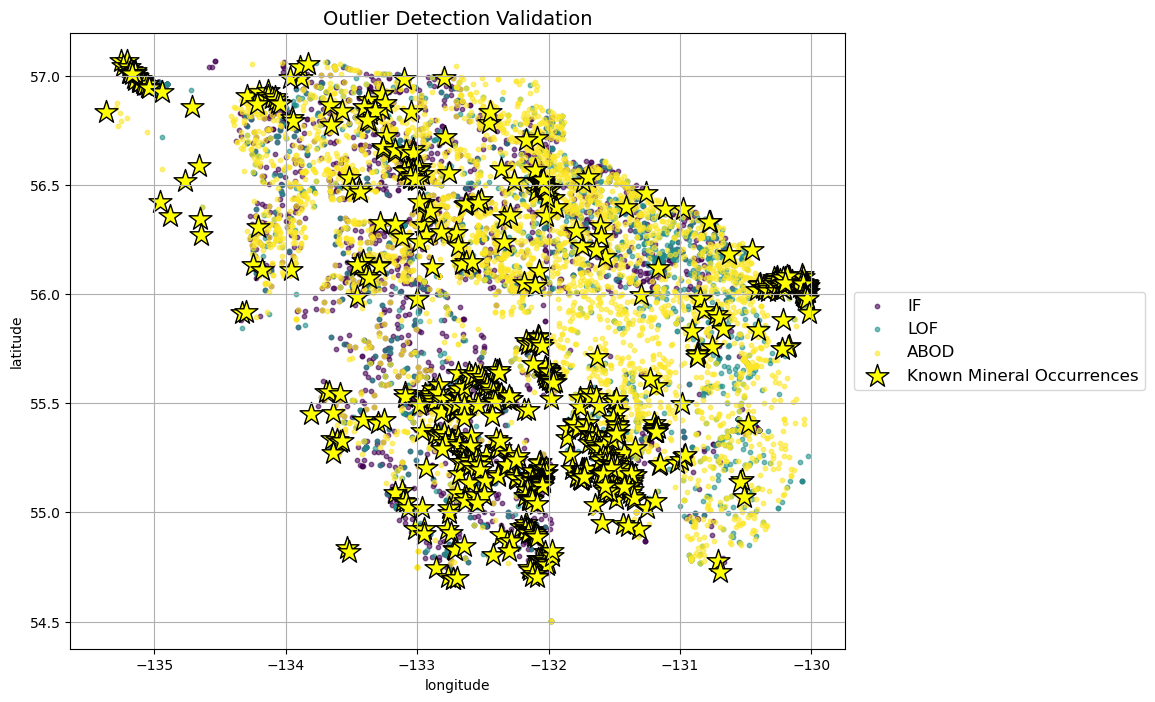

In [62]:
# Plot outlier detection results and validation dataset

outlier_results = [IF_df, LOF_df, ABOD_df]
outlier_result_names = ['IF', 'LOF', 'ABOD']

helper_functions.plot_validation(outlier_datasets=outlier_results, outlier_dataset_names=outlier_result_names, validation_df=validation_df, point_size=10, colormap='viridis', x_col='longitude', y_col='latitude')

---

### *ROC-AUC, ANOVA F-statistic, and Mutual Information scoring of outlier predictions*

To quantitatively compare the different outlier prediction methods, we will use three different scoring methods: ROC-AUC, ANOVA F-statistic, and Mutual Information.
<br />
<br />
- *<u>ROC-AUC, or Receiver Operating Characteristic Area Under the Curve</u>* is a machine learning metric used to evaluate a model's ability to distinguish between positive and negative classes; a score of 1 is considered 'perfect,' or that the model gets 100% of predictions correct. 
    - Generally best for evaluating overall predictive performance, regardless of spatial location.
<br />
<br />
- The *<u>ANOVA F-statistic</u>* is a method of comparing the variances of two samples (in this case the prediction and the validation set); the higher the score, the greater the model's predictions are differentiated. That is, there is a meaningful pattern between predicted outliers and known mineral deposits.
    - Measures how well the model distinguishes spatially relevant anomalies.
<br />
<br />
- *<u>Mutual Information</u>* is a method of measuring how much information one variable provides about another, or how dependent they are on each other. Higher MI values indicate stronger relationships between variables. 
    - Quantifies dependency between outlier predictions and proximity to known deposits.

ROC-AUC Score for IF: 0.6876
ROC-AUC Score for LOF: 0.6539
ROC-AUC Score for ABOD: 0.3841
F-Score for IF: 1027.0057
F-Score for LOF: 3.3922
F-Score for ABOD: 2.1004
Mutual Information Score for IF: 0.0081
Mutual Information Score for LOF: 0.0061
Mutual Information Score for ABOD: 0.0006


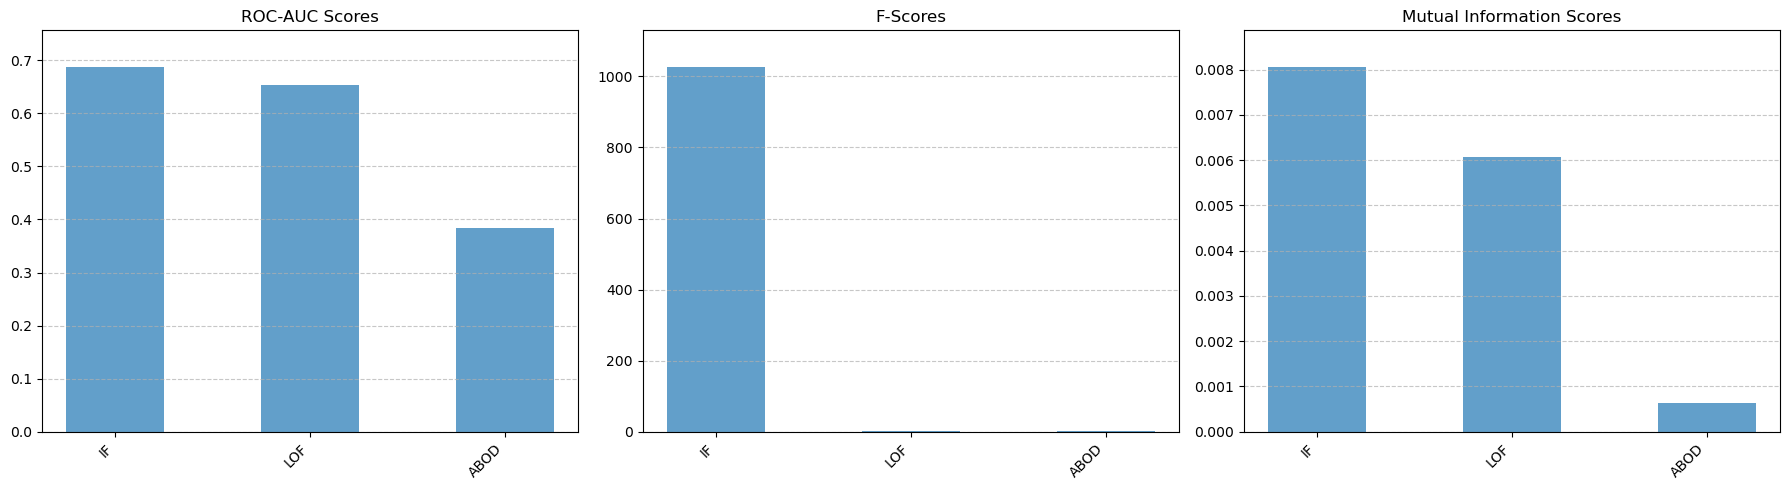

In [26]:
# Calculate scores for each outlier detection method

scoring_radius = 0.005 # roughly 500m

roc_auc_scores = helper_functions.calculate_roc_auc(
    outlier_results,
    outlier_result_names,
    validation_df,
    radius=scoring_radius,
    x_col="longitude",
    y_col="latitude",
)

f_scores = helper_functions.calculate_f_score(
    outlier_results,
    outlier_result_names,
    validation_df,
    radius=scoring_radius,
    x_col="longitude",
    y_col="latitude",
)

mi_scores = helper_functions.calculate_mi_score(
    outlier_results,
    outlier_result_names,
    validation_df,
    radius=scoring_radius,
    x_col="longitude",
    y_col="latitude",
)

helper_functions.plot_scores(
    [roc_auc_scores, f_scores, mi_scores],
    titles=["ROC-AUC Scores", "F-Scores", "Mutual Information Scores"],
)

---

### *Deeper investigation into ROC-AUC scoring of each model*

Since the ROC-AUC scores for each model above are so similar, let's create a ROC curve to better understand the model performance. 

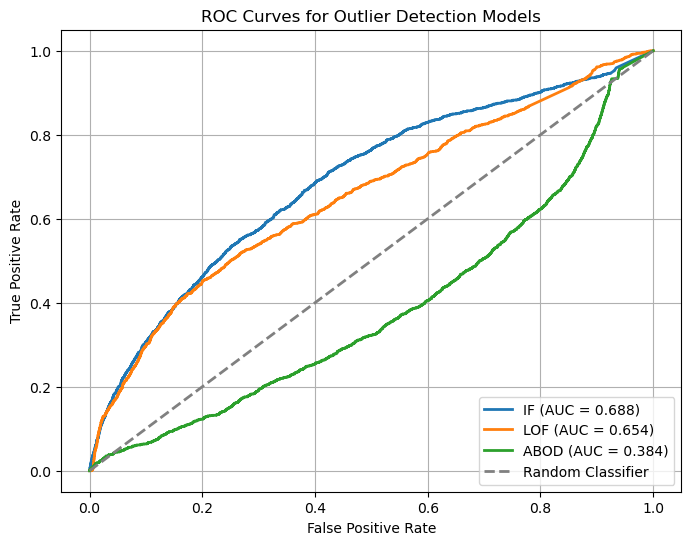

In [61]:
helper_functions.plot_roc_curves(
    outlier_datasets=outlier_results,  # Your outlier model DataFrames
    outlier_dataset_names=outlier_result_names,  # Names of models
    validation_df=validation_df,  # Known mineral deposits
    radius=scoring_radius,
    x_col='longitude', 
    y_col='latitude'
)

The ROC curve above matches the results we observed - the ABOD method appears to best optimize the TPR/FPR ratio, indicating better model performance. 

---

### <u>Time Cost Analysis</u>

Despite the quantitative accuracies between models, it is also important to consider the time cost of each; IF and LOF process almost instantly, while ABOD takes some time due to the nature of the calculation. Optimized versions of the ABOD, such as FastABOD, exist, though they utilize methods such as k-nearest neighbors to calculate variance rather than using all possible pairs in the dataset, potentially skewing results. For relatively small datasets, the time cost of ABOD is minimal, but for larger datasets the tradeoffs should be considered; it may be more efficient to use an algorithm like Isolation Forest despite the small cost in model accuracy.

Below we will do a brief investigation into the time cost of each method, focusing particularly on ABOD.

In [ ]:
# Explore time cost of outlier detection vs. roc-auc score

outlier_models = [
    outlier_detection_functions.isolation_forest, 
    outlier_detection_functions.local_outlier_factor, 
]

outlier_model_names = ['IF', 'LOF']
scoring_radius = 0.005

# Dictionary to store results
results = {
    "Model": [],
    "Iteration": [],
    "Execution Time (s)": [],
    "ROC-AUC Score": []
}

for model, name in zip(outlier_models, outlier_model_names):
    for i in range(7):
        start = time.time()
        output_df = model(df, feature_columns)
        end = time.time()
        exec_time = end - start

        print(f"{model.__name__} iteration {i} took {end - start} seconds")

        roc_auc_score = helper_functions.calculate_roc_auc(
            outlier_datasets=[output_df],
            outlier_dataset_names=[name],
            validation_df=validation_df,
            radius=scoring_radius,
            x_col="longitude",
            y_col="latitude",
        )[name]

        # Store results in dictionary
        results["Model"].append(name)
        results["Iteration"].append(i)
        results["Execution Time (s)"].append(exec_time)
        results["ROC-AUC Score"].append(roc_auc_score)

In [ ]:
# Plot the results of the above analysis

results_df = pd.DataFrame(results)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Box Plot
sns.boxplot(x="Model", y="Execution Time (s)", data=results_df, ax=axes[0])
axes[0].set_title("Execution Times by Model")
axes[0].set_xlabel("Outlier Detection Model")
axes[0].set_ylabel("Execution Time (s)")
axes[0].set_yscale("log")

# Scatter Plot
sns.scatterplot(
    x="Execution Time (s)", y="ROC-AUC Score", hue="Model", data=results_df, ax=axes[1]
)
axes[1].set_title("Execution Time vs. ROC-AUC Score")
axes[1].set_xlabel("Execution Time (s)")
axes[1].set_xscale("log")
axes[1].set_ylabel("ROC-AUC Score")
axes[1].legend(title="Model")

plt.tight_layout()
plt.show()

As we can see in the above plots, IF and LOF have significantly lower execution times. IF seems to strike somewhat of a balance between execution time and ROC-AUC score, indicating it may be more suitable than ABOD for datasets n > ~2000-3000 as the tradeoff between time and score diminishes. 

In [ ]:
# Analyze the execution time of each method with varying sample sizes

# Define sample sizes
sample_sizes = [50, 100, 200, 400, 800, 1600, 2700]

# Measure execution time
#abod_results_df = helper_functions.measure_model_execution(
#    df, sample_sizes, model=outlier_detection_functions.abod
#)

if_results_df = helper_functions.measure_model_execution(
    df, sample_sizes, model=outlier_detection_functions.isolation_forest
)

lof_results_df = helper_functions.measure_model_execution(
    df, sample_sizes, model=outlier_detection_functions.local_outlier_factor
)



In [ ]:
# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# IF
axes[0].plot(
    if_results_df["Number of Samples"],
    if_results_df["Execution Time (s)"],
    marker="o",
    linestyle="-",
)
axes[0].set_xlabel("Number of Samples (Log Scale)")
axes[0].set_xscale("log")  
axes[0].set_ylabel("Execution Time (s)")
axes[0].set_ylim(0.08, 0.12)
axes[0].set_title("IF Method")
axes[0].grid(True, which="both", linestyle="--", linewidth=0.5)

# LOF
axes[1].plot(
    lof_results_df["Number of Samples"],
    lof_results_df["Execution Time (s)"],
    marker="o",
    linestyle="-",
)
axes[1].set_xlabel("Number of Samples (Log Scale)")
axes[1].set_xscale("log")  
axes[1].set_ylabel("Execution Time (s)")
axes[1].set_ylim(0, 0.08)
axes[1].set_title("LOF Method")
axes[1].grid(True, which="both", linestyle="--", linewidth=0.5)

## ABOD
# axes[0].plot(
#    abod_results_df["Number of Samples"],
#    abod_results_df["Execution Time (s)"],
#    marker="o",
#    linestyle="-",
# )
# axes[0].set_xscale("log")
# axes[0].set_yscale("log")
# axes[0].set_xlabel("Number of Samples (Log Scale)")
# axes[0].set_ylabel("Execution Time (s) (Log Scale)")
# axes[0].set_title("ABOD Method")
# axes[0].grid(True, which="both", linestyle="--", linewidth=0.5)

fig.suptitle("Number of Samples vs. Execution Time per Outlier Detection Method")
plt.tight_layout()
plt.show()

As we can see above, ABOD has more similar execution times as IF/LOF (<1s) when n<~200, but beyond that the time cost grows exponentially. IF and LOF distributions are irregular due to the extremely short processing times, and variation can be attributed to random noise; they generally follow an O(n) time complexity, while ABOD appears to follow O(n^2), which aligns with the pairwise computations required to calculate ABOD. 

To summarize, ABOD seems to be the most appropriate model for smaller datasets (n<2000-3000), but beyond that the time cost becomes significant, and IF should be considered as a still plenty-capable alternative. 